In [1]:
import os
import numpy as np
import time
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import sys
from itertools import combinations, permutations

from skimage import io, color
from skimage.transform import resize
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from sklearn import metrics

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms

import torchvision.transforms.functional as TF
from torchvision.models.segmentation import fcn_resnet50
from torchsummary import summary
from torchvision.models import resnet50
from torchvision import models
import torch.nn.functional as F

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
mode = "ids"
# mode = "gender"
# mode = "ethnicity"
ncl = {"ids":100, "gender":2, "ethnicity":7}
num_classes = ncl[mode]
print(num_classes)

100


In [3]:
class EarDataset(Dataset):

    def __init__(self, path, ids, mode=None, train=False):
        self.path = path  # "/content/drive/MyDrive/AWEDataset/awe"
        self.train = train
        self.ids = ids
        self.gender = False
        self.ethnicity = False
        self.all_tags = False
        if mode == "gender":
            self.gender = True
        elif mode == "ethnicity":
            self.ethnicity = True
        elif mode == "all":
            self.all_tags = True
        
        _, folders, _ = next(os.walk(path))

        ## we have to get two images from same person and one from somebody else for one training sample

        self.all = np.array([])
        self.ann = {}

        gen = {"m":0, "f":1} ##change letter to number
        eth = {1:0, 2:1, 3:2, 4:3, 5:4, 6:5, 99:6}

        for f in folders:
            files = list(sorted(os.listdir(os.path.join(path, f))))
            del files[files.index("annotations.json")]
            with open(os.path.join(path, f, "annotations.json")) as js:
                data = json.load(js)
                self.ann[f] = {"ethnicity":eth[data["ethnicity"]], "gender":gen[data["gender"]]}

            for i in range(len(files)):
                files[i] = os.path.join(f,files[i])

            files = [x for x in files if x in self.ids]  ## separate test and train i guess
                
            self.all = np.append(self.all, files)
            
    def get_anns(self):
        return self.ann
        
    def __len__(self):
        return len(self.all)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        tf_compose = transforms.Compose([transforms.ToTensor(),
                                         transforms.Resize((160,84)),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        obj = self.all[idx]
        id_obj = obj[:3]

        if self.gender:
            tag = self.ann[id_obj]["gender"]
        elif self.ethnicity:
            tag = self.ann[id_obj]["ethnicity"]
        elif self.all_tags:
            tag = (self.ann[id_obj]["gender"], self.ann[id_obj]["ethnicity"], int(id_obj)-1)
        else:
            tag = int(id_obj)-1

        img_name = os.path.join(self.path, obj)
        img = io.imread(img_name)

        if len(img.shape) == 2:
            img = color.gray2rgb(img)
        elif img.shape[2] == 4:
            img = img[:,:,:3]

        img = tf_compose(img)
        img = img.type(torch.FloatTensor)

        return img, tag

def my_transforms(image, mask):

    if np.random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)

    if np.random.random() > 0.5:
        angle = np.random.randint(-30, 30)
        image = TF.rotate(image, angle)
        mask = TF.rotate(mask, angle)
        
    return image, mask

In [4]:
import csv
ids = {"train_ids":[], "test_ids":[]}

with open("/content/drive/MyDrive/AWEDataset/awe/awe-translation.csv", newline='') as csvfile:
    r = csv.reader(csvfile, delimiter=',')
    for row in r:
        if row[0][:5]=="train":
            # if int(row[2]) not in ids["train_ids"]:
            #     ids["train_ids"][int(row[2])] = []
            # ids["train_ids"][int(row[2])].append(row[1])
            ids["train_ids"].append(row[1])
        elif row[0][:4]=="test":
            ids["test_ids"].append(row[1])
        else:
            print(row)

print(len(ids["train_ids"]), len(ids["test_ids"]))
print(ids["test_ids"])

['AWE-Full image path', 'AWE image path', 'Subject ID']
750 250
['011/07.png', '011/08.png', '011/09.png', '001/03.png', '012/08.png', '012/09.png', '002/01.png', '012/10.png', '002/02.png', '013/03.png', '014/02.png', '014/10.png', '015/02.png', '015/07.png', '015/03.png', '016/07.png', '016/08.png', '016/09.png', '017/07.png', '017/08.png', '017/09.png', '018/08.png', '018/09.png', '018/10.png', '019/03.png', '020/01.png', '020/02.png', '021/04.png', '021/05.png', '021/02.png', '022/07.png', '022/08.png', '022/09.png', '023/07.png', '023/08.png', '023/09.png', '003/04.png', '024/08.png', '024/09.png', '003/05.png', '024/10.png', '003/06.png', '025/03.png', '026/01.png', '026/04.png', '027/04.png', '027/05.png', '027/01.png', '028/07.png', '028/08.png', '028/02.png', '029/02.png', '029/09.png', '029/10.png', '030/09.png', '030/10.png', '030/02.png', '031/03.png', '032/01.png', '032/04.png', '033/05.png', '033/01.png', '033/06.png', '034/01.png', '034/08.png', '034/02.png', '035/06.png

In [5]:
gender_dict = {0:"Male", 1:"Female"}
ethnicity_dict = {1:"White", 2:"Asian", 3:"South Asian", 4:"Black", 5:"Middle Eastern", 6:"South American", 99:"Other"}

750


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

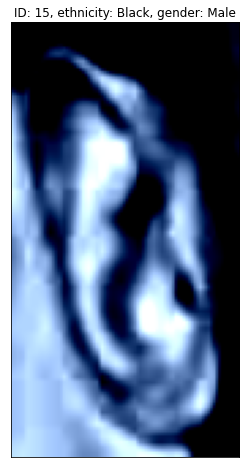

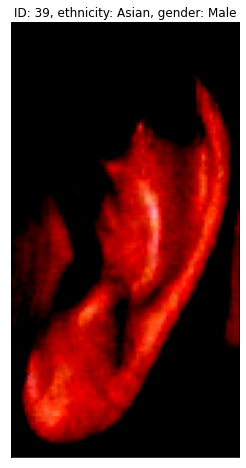

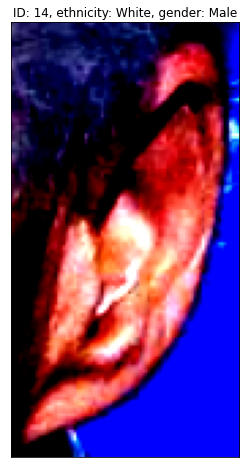

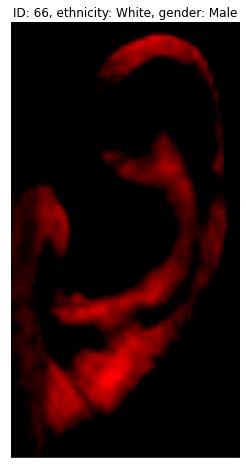

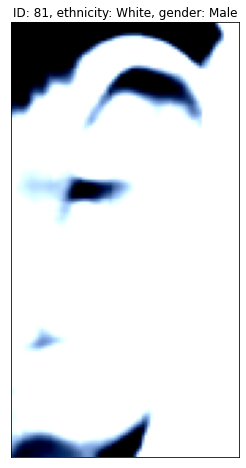

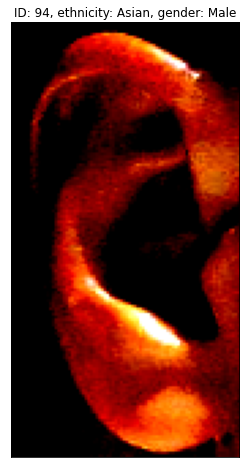

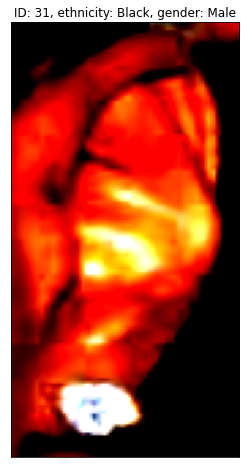

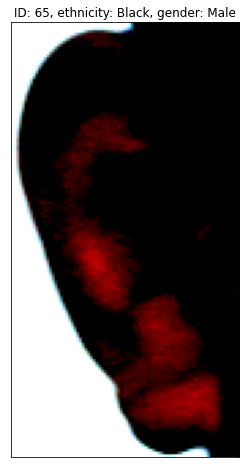

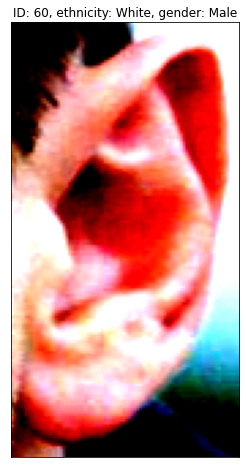

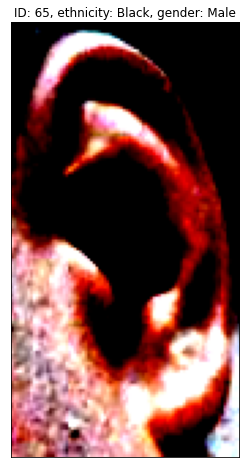

In [17]:
dataset = EarDataset(path="/content/drive/MyDrive/AWEDataset/awe", ids=ids["train_ids"], mode="all")
print(len(dataset))
dat = DataLoader(dataset, shuffle=True, num_workers=4, batch_size=1)
def show_dataset(dataset, num):
    for a, b in enumerate(dat):
        if a>=num:
            break
        img, tag = b
        gen, et, id = tag

        img = img[0].permute(1, 2, 0).detach().cpu().numpy()

        plt.figure(figsize=(15, 8))
        #plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title(f"ID: {int(id)+1}, ethnicity: {ethnicity_dict[int(et)+1]}, gender: {gender_dict[int(gen)]}")
        plt.xticks([])
        plt.yticks([])
        # plt.savefig(f"/content/drive/MyDrive/ear{a}.png", bbox_inches="tight")

show_dataset(dataset, 10)

In [36]:
def get_model(device, num_classes=0, path_model = None, train = False, all=None, lr=1e-4):  ## all = [2, 7, 100] - num classes gender, ethnicity, id
    
    if all is not None:
        class Model(nn.Module):
            def __init__(self, all):
                super(Model, self).__init__()
                self.model = models.resnet50(pretrained=True)
                ft = self.model.fc.in_features
                self.model.fc = nn.Identity()
                
                self.fc_gender = nn.Linear(ft, all[0])
                self.fc_ethnicity = nn.Linear(ft, all[1])
                self.fc_id = nn.Linear(ft, all[2])
                
            def forward(self, x):
                x = self.model(x)
                x1 = self.fc_gender(x)
                x2 = self.fc_ethnicity(x)
                x3 = self.fc_id(x)
                return x1, x2, x3
        model = Model(all)

    else:
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(2048, 1024)
        model.add_module("lin1", nn.Linear(1024, 512))
        model.add_module("lin2", nn.Linear(512, num_classes))

    if path_model:
        print("loading...")

        checkpoint = torch.load(path_model, map_location=device)
        print(checkpoint["epoch"])
        model.load_state_dict(checkpoint['model_state_dict'])

        if train:
            model.to(device)
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            epoch_start = checkpoint['epoch']

            return model, optimizer, epoch_start

    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    epoch_start = 0

    return model, optimizer, epoch_start

loading...
6
EPOCH 0:
94it [00:49,  1.90it/s]                        
TRAIN: loss: 0.033, acc: 0.996
--------------------------------------------------------------------------------
EPOCH 1:
94it [00:06, 14.62it/s]
TRAIN: loss: 0.010, acc: 0.995
Saving model...
--------------------------------------------------------------------------------
EPOCH 2:
94it [00:06, 13.96it/s]                        
TRAIN: loss: 0.011, acc: 0.997
--------------------------------------------------------------------------------
EPOCH 3:
94it [00:07, 13.13it/s]                        
TRAIN: loss: 0.086, acc: 0.975
--------------------------------------------------------------------------------
EPOCH 4:
94it [00:06, 15.09it/s]                        
TRAIN: loss: 0.025, acc: 0.992
--------------------------------------------------------------------------------
EPOCH 5:
94it [00:06, 14.45it/s]                        
TRAIN: loss: 0.015, acc: 0.997
--------------------------------------------------------------

TypeError: ignored

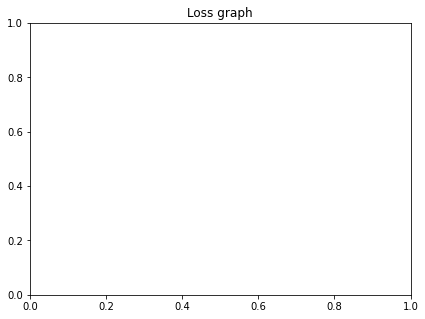

In [15]:
def train(device, train_set, model, optimizer, epoch_start, path_model_save, num_epochs = 1,  batch_size = 8, all=None):
    keys = ["gender", "ethnicity", "id"]
    dataloader_train = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers=4)

    min_loss = 0  # valid : (min_loss, count_since_min_loss)
    if all is not None:
        loss_log = {k:[] for k in keys}
        graph_loss = {k:[] for k in keys}
        graph_acc = {k:[] for k in keys}
    else:
        loss_log = []
        graph_loss = []
        graph_acc = []

    acc_log = {"train": np.array([]), "valid": np.array([])}

    criterion = nn.CrossEntropyLoss()

    t1 = time.time()
    for epoch in range(num_epochs):
        print(f"EPOCH {epoch}:")
        t2 = time.time()

        ### TRAIN
        if all is not None:
            tags = {k:[] for k in keys}
            outs = {k:[] for k in keys}
        else:
            tags = []
            outs = []

        model.train()
        len_tr = int(len(train_set) / batch_size)

        for i, batch in tqdm(enumerate(dataloader_train), total=len_tr, position=0, leave=True, file=sys.stdout, ascii=True):
            img, tag = batch
            img = img.to(device)

            out = model(img)

            if all is not None:
                tag = {k:t for k, t in zip(keys, tag)}
                out = {k:o for k, o in zip(keys, out)}

                loss_all = {k:criterion(out[k].float(), tag[k].to(device)) for k in keys}
                #loss = loss_all["gender"] + loss_all["ethnicity"] + loss_all["id"]  #torch.sum(torch.tensor([loss_all[i] for i in keys]))
                loss_all["gender"].backward(retain_graph=True)
                loss_all["ethnicity"].backward(retain_graph=True)
                loss_all["id"].backward(retain_graph=True)

            
            else:
                loss = criterion(out.float(), tag.to(device))

                loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            if all is not None:
                [loss_log[k].append(loss_all[k].cpu().detach().numpy().squeeze()) for k in keys]
                [tags[k].append(tag[k].numpy()) for k in keys]
                [outs[k].append(np.argmax(out[k].float().detach().cpu().numpy(), axis=1)) for k in keys]

            else:
                loss_log.append(loss.cpu().detach().numpy().squeeze())

                tags.append(tag.numpy())
                outs.append(np.argmax(out.float().detach().cpu().numpy(), axis=1))

        if all is not None:
            avg_loss_tr = {k:np.mean(loss_log[k][-len_tr:]) for k in keys}
            avg_acc_tr = {k:accuracy_score(np.concatenate(tags[k], axis=0), np.concatenate(outs[k], axis=0)) for k in keys}

            [graph_loss[k].append(avg_loss_tr[k]) for k in keys]
            [graph_acc[k].append(avg_acc_tr[k]) for k in keys]

            avg_avg_loss = np.mean([avg_loss_tr[k] for k in keys])
            
            to_save = True if avg_avg_loss < min_loss else False
            min_loss = min_loss if min_loss > 0 else avg_avg_loss

            t3 = time.time()
            print(f"TRAIN:")
            [print(f"{k:>12}: loss: {avg_loss_tr[k]:.3f}, acc: {avg_acc_tr[k]:.3f}") for k in keys]

        else:
            avg_loss_tr = np.mean(loss_log[-len_tr:])
            avg_acc_tr = accuracy_score(np.concatenate(tags, axis=0), np.concatenate(outs, axis=0))

            graph_loss.append(avg_loss_tr)
            graph_acc.append(avg_acc_tr)

            to_save = True if avg_loss_tr < min_loss else False
            min_loss = min_loss if min_loss > 0 else avg_loss_tr

            t3 = time.time()
            print(f"TRAIN: loss: {avg_loss_tr:.3f}, acc: {avg_acc_tr:.3f}")


        if to_save:
            min_loss = avg_loss_tr if all is None else avg_avg_loss
            
            torch.save({'epoch': epoch + epoch_start, 
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': min_loss
                        }, path_model_save)
            print("Saving model...")

        print("-"*80)

    t5 = time.time()
    print(f"Elapsed time: {(t5-t1)/60:.3f} min")
    return graph_loss, graph_acc

# keys = ["gender", "ethnicity", "id"]
# dataset = EarDataset(path="/content/drive/MyDrive/AWEDataset/awe", ids = ids["train_ids"])

# #model, opt, es = get_model(device, path_model="/content/drive/MyDrive/sb-models/model-gender.pt", train=True, all=[2,7,100]) 
# model, opt, es = get_model(device, all=[2, 7, 100], train=True, lr=1e-4)
# graph_loss, graph_acc = train(device, dataset, model = model, optimizer=opt, epoch_start=es, path_model_save="/content/drive/MyDrive/sb-models/model-gender.pt", num_epochs=10, batch_size=8, all=keys)

# plt.figure(figsize=(15,5))
# plt.subplot(1, 2, 1)
# plt.title("Loss graph")
# for k in keys:
#     plt.plot(graph_loss[k], label = k)
# plt.xlabel("epochs")
# plt.ylabel("loss")
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.title("acc graph")
# for k in keys:
#     plt.plot(graph_acc[k], label = k)
# plt.xlabel("epochs")
# plt.ylabel("acc")
# plt.legend()

loading...
18
250
100%|##########| 250/250 [00:03<00:00, 67.68it/s]
Ethnicity classification report
                precision    recall  f1-score   support

         White       0.88      0.87      0.88       153
         Asian       0.72      0.70      0.71        47
   South Asian       0.50      1.00      0.67         3
         Black       0.66      0.72      0.69        29
Middle Eastern       1.00      0.57      0.73         7
South American       0.50      0.62      0.56         8
         Other       1.00      0.33      0.50         3

      accuracy                           0.80       250
     macro avg       0.75      0.69      0.67       250
  weighted avg       0.81      0.80      0.80       250

--------------------------------------------------------------------------------
Gender classification report
              precision    recall  f1-score   support

        Male       1.00      0.99      1.00       229
      Female       0.91      1.00      0.95        21

    acc

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


top 1:0.564, top 5:0.812, per:0.8520363636363636, rec:0.564
Top k acc: [0.564, 0.696, 0.732, 0.788, 0.812, 0.828, 0.852, 0.86, 0.872, 0.9, 0.908, 0.908, 0.924, 0.944, 0.944, 0.952, 0.952, 0.952, 0.952, 0.952, 0.952, 0.956, 0.964, 0.964, 0.964, 0.968, 0.968, 0.968, 0.968, 0.968, 0.968, 0.968, 0.968, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.976, 0.976, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.988, 0.988, 0.992, 0.992, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
77
--------------------------------------------------------------------------------
Final results
      gender: Loss: 0.000, Accuracy: 0.992
   ethnicity: Loss: 0.001, Accuracy: 0.800
          id: Loss: 1.619, Accuracy: 0.564


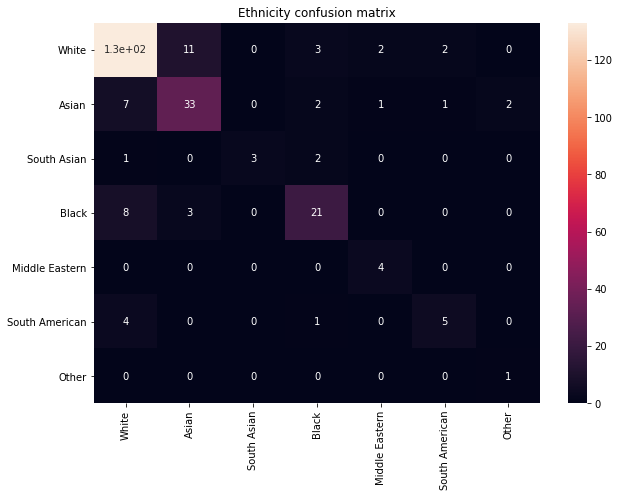

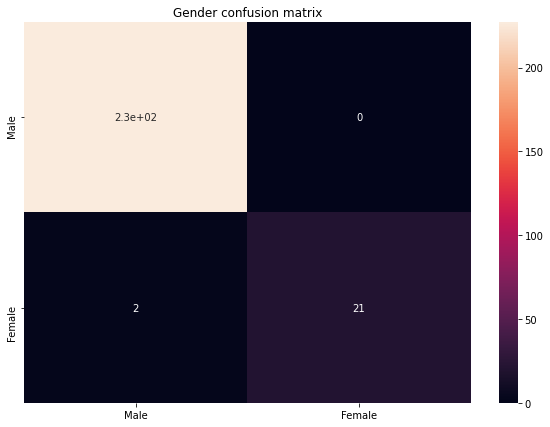

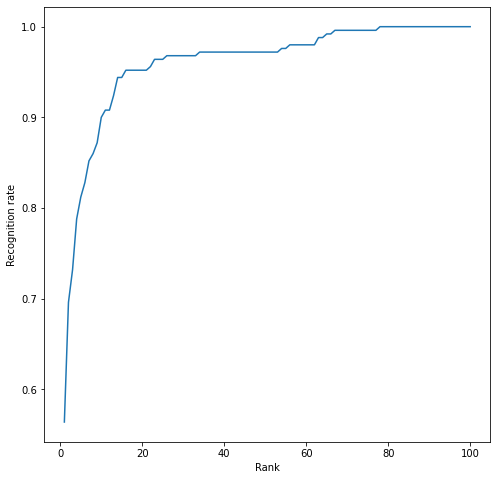

In [37]:
def test(device, model, dataset, num_classes=0, mode="all", top_k=0, keys=None):

    dataloader = DataLoader(dataset, batch_size = 1, shuffle = False, num_workers=4)

    model.eval()
    if keys is not None:
        losses = {k:[] for k in keys}
        tags = {k:[] for k in keys}
        outs = {k:[] for k in keys}
    else:
        tags = []
        outs = []
        losses = []

    criterion = nn.CrossEntropyLoss()

    guesses = {i+1:[] for i in range(top_k)}

    for i, batch in tqdm(enumerate(dataloader), total=len(dataset), position=0, leave=True, file=sys.stdout, ascii=True):
        img, tag = batch
        img = img.to(device)

        with torch.no_grad():
            out = model(img)

        if keys is not None:
            tag = {k:t for k, t in zip(keys, tag)}
            out = {k:o for k, o in zip(keys, out)}

            loss_all = {k:criterion(out[k].float(), tag[k].to(device)) for k in keys}

            [losses[k].append(loss_all[k].cpu().detach().numpy().squeeze()) for k in keys]

            [tags[k].append(tag[k].numpy()) for k in keys]
            [outs[k].append(np.argmax(out[k].float().detach().cpu().numpy(), axis=1)) for k in keys]

            out = {k:out[k].float().detach().cpu().numpy()[0] for k in keys}

            cand = [np.where(out["id"]==x)[0][0] for x in sorted(out["id"], reverse=True)[:top_k+1]]

            for i in range(top_k):
                guess = int(tag["id"]) if int(tag["id"]) in cand[:i+1] else 0
                guesses[i+1].append(guess)

        else:
            loss = criterion(out.float(), tag.to(device))
            losses.append(loss.detach().cpu().numpy())

            if mode in ["gender","ethnicity"]:
                out = np.argmax(out.float().detach().cpu().numpy(), axis=1)
                outs.append(out)
            else:
                out = out.float().detach().cpu().numpy()[0]
                cand = [np.where(out==x)[0][0] for x in sorted(out, reverse=True)[:top_k+1]]

                for i in range(top_k):
                    guess = int(tag) if int(tag) in cand[:i+1] else 0
                    guesses[i+1].append(guess)

            tags.append(tag.numpy())
        

    if keys is not None:
        acc_all = dict()
        acc_all["gender"] = accuracy_score(tags["gender"], outs["gender"]) 
        acc_all["ethnicity"] = accuracy_score(tags["ethnicity"], outs["ethnicity"]) 
        print("Ethnicity classification report")
        labels = ["White", "Asian", "South Asian", "Black", "Middle Eastern", "South American", "Other"]
        print(classification_report(tags["ethnicity"], outs["ethnicity"], labels=list(range(7)), target_names=labels, digits=5))
        
        #### confusion matrix
        cm = metrics.confusion_matrix(outs["ethnicity"], tags["ethnicity"], labels=list(range(7)))
        import seaborn as sn
        import pandas as pd
        df_cm = pd.DataFrame(cm, index = labels, columns = labels)
        plt.figure(figsize = (10,7))
        plt.title("Ethnicity confusion matrix")
        sn.heatmap(df_cm, annot=True)
        ####

        print("-"*80)
        labels = ["Male", "Female"]
        print("Gender classification report")
        print(classification_report(tags["gender"], outs["gender"], labels=list(range(2)), target_names=labels, digits=5))

        #### confusion matrix
        cm = metrics.confusion_matrix(outs["gender"], tags["gender"], labels=list(range(2)))
        df_cm = pd.DataFrame(cm, index = labels, columns = labels)
        plt.figure(figsize = (10,7))
        plt.title("Gender confusion matrix")
        sn.heatmap(df_cm, annot=True)

        print("-"*80)
        print("Id results")
        acc = [accuracy_score(tags["id"], guesses[i+1]) for i in range(top_k)]
        rec = [recall_score(tags["id"], guesses[i+1], labels=list(range(100)), average="weighted") for i in range(top_k)]
        per = [precision_score(tags["id"], guesses[i+1], labels=list(range(100)), average="weighted") for i in range(top_k)]
        print(f"top 1:{acc[0]}, top 5:{acc[4]}, per:{per[0]}, rec:{rec[0]}")

        plt.figure(figsize=(8, 8))
        plt.plot(list(range(1,top_k+1)), acc)
        plt.xlabel("Rank")
        plt.ylabel("Recognition rate")
        print(f"Top k acc: {acc}")
        print(np.argmax(acc))
        acc_all["id"] = acc[0]

        ls = {k:np.mean(losses[k][0]) for k in keys}

        print("-"*80)
        print("Final results")
        [print(f"{k:>12}: Loss: {ls[k]:.3f}, Accuracy: {acc_all[k]:.5f}") for k in keys]

    else:
        if mode == "ethnicity":
            acc = accuracy_score(tags, outs)
            print(classification_report(tags, outs, labels=list(range(num_classes)), target_names=["White", "Asian", "South Asian", "Black", "Middle Eastern", "South American", "Other"], digits=5)) 

        elif mode == "gender":
            acc = accuracy_score(tags, outs)
            print(classification_report(tags, outs, labels=list(range(num_classes)), target_names=["Male", "Female"], digits=5))
        else:
            acc = [accuracy_score(tags, guesses[i+1]) for i in range(top_k)]
            rec = [recall_score(tags, guesses[i+1], zero_division=1, average="weighted") for i in range(1)]
            per = [precision_score(tags, guesses[i+1], zero_division=1, average="weighted") for i in range(1)]
            print(f"top 1:{acc[0]}, top 5:{acc[4]}, per:{per}, rec:{rec}")

            plt.figure(figsize=(8, 8))
            plt.plot(list(range(1,top_k+1)), acc)
            plt.xlabel("Rank")
            plt.ylabel("Recognition rate")
            print(f"Top k acc: {acc}")
            print(np.argmax(acc))
            acc = acc[0]
        
            #print(classification_report(tags, guesses[0], labels=list(range(num_classes))))

        ls = np.mean(losses)
        print(f"Loss: {ls:.5f}, Accuracy: {acc:.5f}")
    

dataset_test = EarDataset(path = "/content/drive/MyDrive/AWEDataset/awe", ids=ids["test_ids"], mode="all")
model, _, _ = get_model(device, path_model="/content/drive/MyDrive/sb-models/model-all-graph.pt", all=[2,7,100])

print(len(dataset_test))
test(device, model, dataset_test, top_k=100, mode="all", keys=["gender", "ethnicity", "id"])